In [215]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [216]:
import numpy as np
import tensorflow as tf

import ND_north_star.src.noise_generators.perlin_noise_generator as PNG # type: ignore
import ND_north_star.src.edge_detection.gradient_detection as ED_sim # type: ignore

In [217]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Disable GPU

In [218]:
tf.config.set_visible_devices([], 'GPU')

In [219]:
import tensorflow as tf
y_true = tf.constant([[1,0,1],[0,0,0],[1,0,0]])
y_pred = tf.constant([[0.9,0.8,0.95],[0.1,0.1,0.1],[0.9,0.1,0.1]])

## Generate dataset

In [220]:
resolution = 60
octaves = 4
dataset_size = 1024
drop_percs = [x/100 for x in range(0, 100, 5)]
# drop_percs = [0.5]

In [221]:
data_path = "data/"
if not os.path.exists(data_path):
    os.makedirs(data_path)
data_path = "data/"

In [222]:
dataset = np.array([PNG.ND_perlin_matrix([resolution, resolution], octaves=octaves, noise_cutoff_list=[0.5, 0, 1]) for _ in range(dataset_size)])
np.save(data_path+'{resolution}x{resolution}_{octaves}_{dataset_size}_dataset.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size), dataset)

In [223]:
# dataset = np.load(data_path+'{resolution}x{resolution}_{octaves}_{dataset_size}_dataset.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size))

Drop data points with respect to each `drop_perc` in `drop_percs`. Then fill the dropped areas by 

In [224]:
seed = 3834
X = np.zeros((len(drop_percs), dataset_size, resolution, resolution))
for i, drop_perc in enumerate(drop_percs):
    X[i] = dataset.copy()
    if drop_perc == 0:
        pass
    else:
        for j in range(dataset_size):
            np.random.seed(seed + j)
            drop_indices = np.random.choice(resolution * resolution, int(resolution * resolution * drop_perc), replace=False)
            x_coords = drop_indices // resolution
            y_coords = drop_indices % resolution
            for k in range(int(resolution * resolution * drop_perc)):
                X[i][j][x_coords[k]][y_coords[k]] = 0
    
    # np.save(data_path+'{resolution}x{resolution}_{octaves}_{dataset_size}_{drop_perc}_X.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size, drop_perc=drop_perc), X[i])

Use gradient edge detection to generate edges.

In [225]:
y = np.array([ED_sim.gradient_edge_detection(dataset[i]) for i in range(dataset_size)]).astype(int)

# np.save(data_path+'{resolution}x{resolution}_{octaves}_{dataset_size}_y.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size), y)

## Train test split

In [226]:
from sklearn.model_selection import train_test_split

In [227]:
indices_train = [0 for _ in range(len(drop_percs))]
indices_test = [0 for _ in range(len(drop_percs))]

In [228]:
for i in range(len(drop_percs)):
    indices_train[i], indices_test[i] = train_test_split(range(dataset_size), random_state=seed+i)

## CNN

In [229]:
from tensorflow import keras
from keras import models
from keras import layers
from sklearn.metrics import mean_squared_error

In [230]:
model_path = "checkpoints/"
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [231]:
import tensorflow.keras.backend as K

def my_loss_func(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    a = tf.reduce_sum(y_true_f)/y_true_f.shape[0]
    b = 1 - a
    return -a*tf.experimental.numpy.inner(1-y_true_f, tf.math.log(1-y_pred_f))-b*tf.experimental.numpy.inner(y_true_f, tf.math.log(y_pred_f))

In [242]:
epochs = 100
batch_size = 32

history = [None for _ in range(len(drop_percs))]
pred_continuous = [None for _ in range(len(drop_percs))]
threshold = 0.5
pred_discrete = [None for _ in range(len(drop_percs))]
mses = np.zeros(len(drop_percs))

for i, drop_perc in enumerate(drop_percs):
    model = models.Sequential([
        layers.InputLayer((resolution,resolution,1,)),
        layers.Conv2D(32, (3,3), activation='relu', padding = 'same'),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same')
    ])
    model.compile(optimizer='adam',
                    loss='mse',
                    # loss=my_loss_func,
                    # loss='categorical_crossentropy',
                    metrics=[my_loss_func])

    X_train = X[i][indices_train[i]]
    y_train = y[indices_train[i]]
    X_test = X[i][indices_test[i]]
    y_test = y[indices_test[i]]

    X_train_tensor = tf.convert_to_tensor(X_train)
    y_train_tensor = tf.convert_to_tensor(y_train)
    X_test_tensor = tf.convert_to_tensor(X_test)
    y_test_tensor = tf.convert_to_tensor(y_test)

    history[i] = model.fit(X_train_tensor, y_train_tensor, validation_data=(X_test_tensor, y_test_tensor),
                      epochs=epochs, 
                      batch_size=batch_size)
    
    model.save(model_path+"edge_{resolution}x{resolution}_{octaves}_{dataset_size}_{drop_perc}_{epochs}.keras".format(resolution=resolution, octaves=octaves, dataset_size=dataset_size, drop_perc=drop_perc, epochs=epochs))

    pred_continuous[i] = model.predict(X_test_tensor)
    # np.save(data_path+'{resolution}x{resolution}_{octaves}_{dataset_size}_{drop_perc}_{epochs}_pred.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size, drop_perc=drop_perc, epochs=epochs), pred[i])

    pred_discrete[i] = np.array([a>threshold for a in pred_continuous[i]]).reshape(y_test.shape).astype(int)
    # np.save(data_path+'{resolution}x{resolution}_{octaves}_{dataset_size}_{drop_perc}_{epochs}_pred01.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size, drop_perc=drop_perc, epochs=epochs), pred_01[i])

    mses[i] = np.mean([mean_squared_error(y_test[j], pred_discrete[i][j]) for j in range(len(y_test))])

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.1946 - my_loss_func: 20328.4141 - val_loss: 0.1258 - val_my_loss_func: 38562.4883
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.1201 - my_loss_func: 39752.0938 - val_loss: 0.1044 - val_my_loss_func: 28934.0996
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.1024 - my_loss_func: 25671.1230 - val_loss: 0.0970 - val_my_loss_func: 24315.8770
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0951 - my_loss_func: 23200.0352 - val_loss: 0.0884 - val_my_loss_func: 20548.6523
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0858 - my_loss_func: 19662.3359 - val_loss: 0.0769 - val_my_loss_func: 16823.6465
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0733 - my_loss_func: 15843.4941 - val_loss: 0.0619 - val_my_loss_func: 12734.3047
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0591 - my_loss_func: 12176.6201 - val_loss: 0.0525 - val_my_loss_func: 107

In [233]:
np.save(data_path+'edge_{resolution}x{resolution}_{octaves}_{dataset_size}_{epochs}_mses.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size, epochs=epochs), mses)

In [234]:
np.save(data_path+'edge_{resolution}x{resolution}_{octaves}_{dataset_size}_{epochs}_pred.npy'.format(resolution=resolution, octaves=octaves, dataset_size=dataset_size, epochs=epochs), pred_continuous)

Training curves

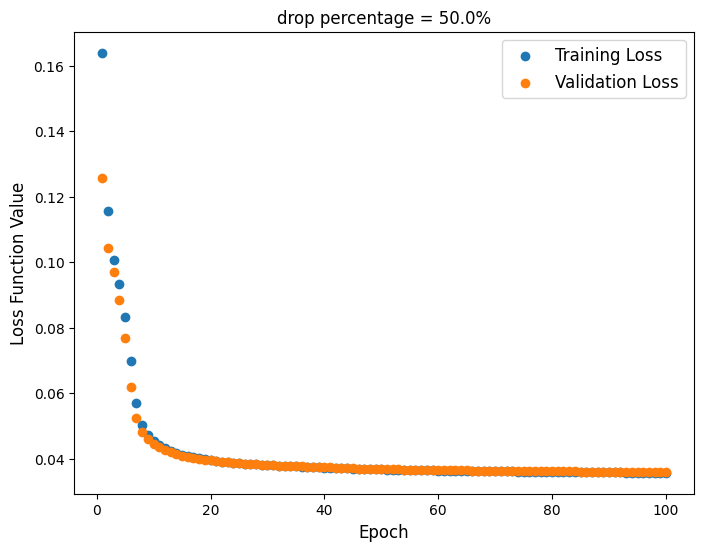

In [243]:
import matplotlib.pyplot as plt

for i, drop_perc in enumerate(drop_percs):
    plt.figure(figsize = (8,6))
    plt.scatter(range(1, epochs + 1),history[i].history['loss'], label = "Training Loss")
    plt.scatter(range(1, epochs + 1),history[i].history['val_loss'], label = "Validation Loss")

    plt.title("drop percentage = {drop_perc}%".format(drop_perc=drop_perc*100))
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss Function Value", fontsize=12)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.legend(fontsize=12)

    plt.show()

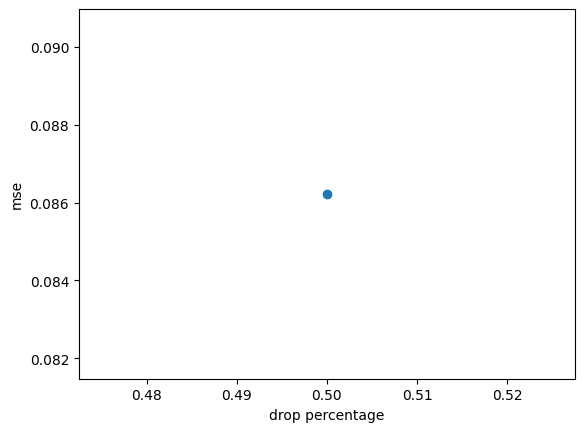

In [236]:
import matplotlib.pyplot as plt

plt.plot(drop_percs, mses, marker='o')
plt.xlabel("drop percentage")
plt.ylabel("mse")
plt.show()

## Some visualization

In [244]:
m = 0
n = 20
nn = indices_test[m][n]

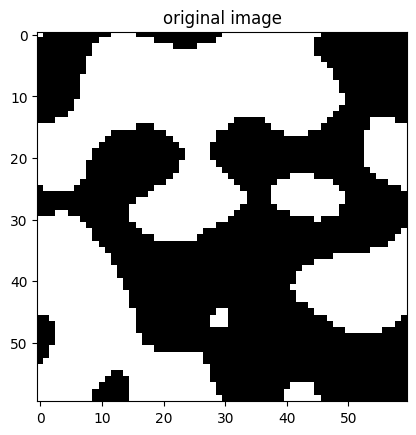

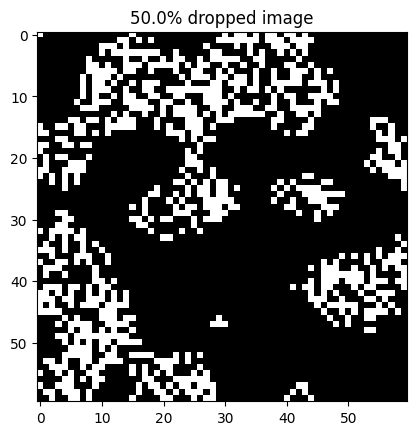

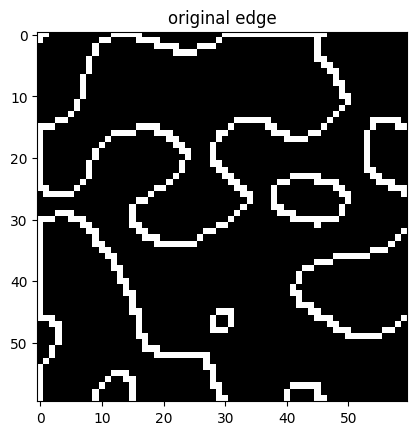

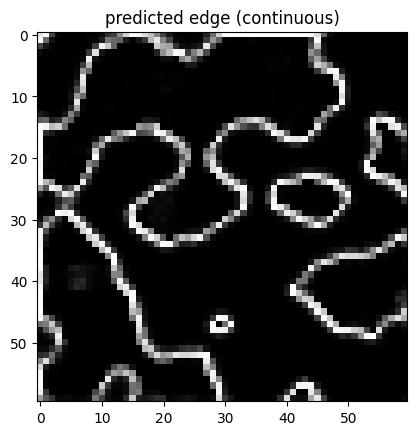

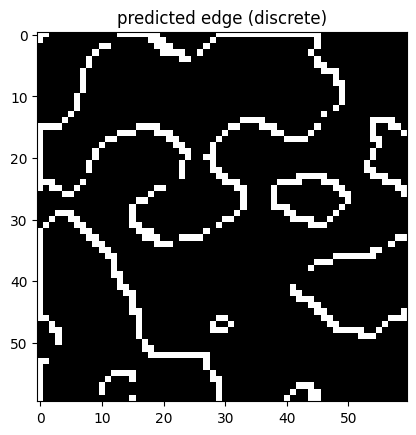

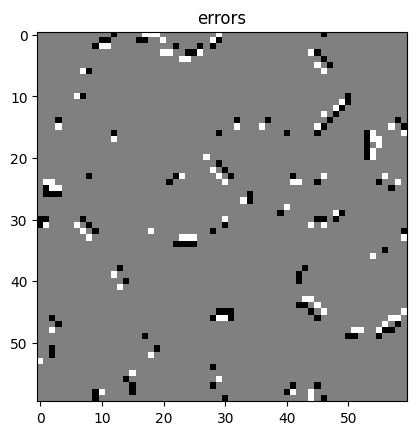

In [245]:
plt.imshow(dataset[nn], cmap='gray')
plt.title("original image")
plt.show()
plt.imshow(X[m][indices_test[m]][n], cmap='gray')
plt.title("{drop_perc}% dropped image".format(drop_perc = drop_percs[m]*100))
plt.show()
plt.imshow(y[indices_test[m]][n], cmap='gray')
plt.title("original edge")
plt.show()
plt.imshow(pred_continuous[m][n], cmap='gray')
plt.title("predicted edge (continuous)")
plt.show()
plt.imshow(pred_discrete[m][n], cmap='gray')
plt.title("predicted edge (discrete)")
plt.show()
plt.imshow(pred_discrete[m][n]-y[indices_test[m]][n], cmap='gray')
plt.title("errors")
plt.show()
